# HR Analytics: Job Change of Data Scientists - Day 2
##### Author :  Dayananda Ubrangala

In [1]:
##### Let us import some import require libraries for analysing the HR data

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # to set up the working directory

# Visualisation python lib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

path = 'C:/backup/StudyMaterials/BITS Workshop/python_ana'
os.chdir(path)

In [2]:
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

In [3]:
## Jupyter notebook display setting
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load Data

In [4]:
#Importing Datasets
data = pd.read_csv("hr_analytics_engineered_features.csv")

In [5]:
## Data dimension
data.shape

(19158, 222)

In [6]:
## Look at the data header
data.head(2)

,relevent_experience,enrollee_id,city_development_index,training_hours,target_var,city,gender,enrolled_university,education_level,major_discipline,...,dummy_company_type_ngo,dummy_company_type_other,dummy_company_type_public sector,dummy_company_type_pvt ltd,dummy_last_new_job_1,dummy_last_new_job_2,dummy_last_new_job_3,dummy_last_new_job_4,dummy_last_new_job__4,dummy_last_new_job_never
0,Has relevent experience,8949,0.920,36,1,city_103,Male,no_enrollment,Graduate,STEM,...,0,0,0,1,1,0,0,0,0,0
1,No relevent experience,29725,0.776,47,0,city_40,Male,no_enrollment,Graduate,STEM,...,0,0,0,1,0,0,0,0,1,0


In [7]:
#### Selected features post feature reduction
import joblib
my_independet_var_list = joblib.load("selected_features1") 
len(my_independet_var_list)

199

### Split Data

In [8]:
## sample returns a random sample from an axis of the object. That would be 18,200 samples, not 19,158
dataset = data.sample(frac=0.95, random_state=123)
dataset.shape

(18200, 222)

In [9]:
# Unseen data (5% of total sample)
data_unseen = data.drop(dataset.index)
data_unseen.shape

(958, 222)

In [10]:
## we reset the index of both datasets
dataset.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(dataset.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (18200, 222)
Unseen Data For Predictions: (958, 222)


In [11]:
#splitiing data for test and train for validation purpose
from sklearn.model_selection import train_test_split

# create x and y train
X = dataset[my_independet_var_list]
y = dataset.target_var.values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, stratify = y,random_state=41)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((14560, 199), (3640, 199), (14560,), (3640,))

In [12]:
from collections import Counter
print("Train Size", Counter(y_train))
print("Test Size", Counter(y_valid))

Train Size Counter({0: 10931, 1: 3629})
Test Size Counter({0: 2733, 1: 907})


**Data is ready now-- Lets start Model building**

In [13]:
### My Model Evaluation Function
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score, log_loss, roc_auc_score, accuracy_score
def my_class_pred_function (model_object, dpred, yactual, mlname):
    pred_class = model_object.predict(dpred)
    pred_prob = model_object.predict_proba(dpred)
    roc_auc = roc_auc_score(yactual, pred_prob[:,1])
    aac_val = accuracy_score(yactual, pred_class)
    f1_test = f1_score(yactual, pred_class)
    recall_v1 = recall_score(yactual, pred_class)
    precision_v1 = precision_score(yactual, pred_class)
    data = {'model_name':[mlname], 'acc':[aac_val],'auc':[roc_auc], 'f1_score':[f1_test], 'recall':[recall_v1], 'precision':[precision_v1]}
    mydata = pd.DataFrame(data)
    return(mydata)

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


### 1. Random Forest Model

In [14]:
## Import libraries
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


##### 1. Defalut parameter RF Model

In [15]:
rf1_v1 = RandomForestClassifier(random_state = 0)
rf1_v1.fit(X_train, y_train)

#predicting test set
y_rf1 = rf1_v1.predict(X_valid)
accuracy_score(y_valid, y_rf1)

0.7714285714285715

<AxesSubplot:>

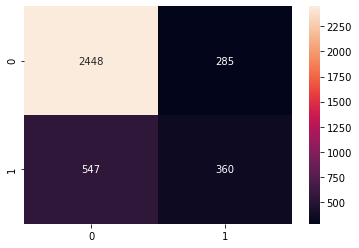

In [16]:
cm_base =  confusion_matrix(y_valid, y_rf1)
sns.heatmap(cm_base, annot=True, fmt="d")

In [17]:
my_class_pred_function (rf1_v1, X_valid, y_valid, "RF Base")

,model_name,acc,auc,f1_score,recall,precision
0,RF Base,0.771429,0.776113,0.463918,0.396913,0.55814


#####  2. Using RandomSearch to find the optimal parameters
RandomizedSearchCV randomly goes through the combination of parameters and gives the best one found. It does not give the absolute best parameters but its usually pretty close and helps in reducing the iteratons in Gridsearch

In [18]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf = RandomForestClassifier(random_state = 99)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   41.8s remaining:   36.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

<AxesSubplot:>

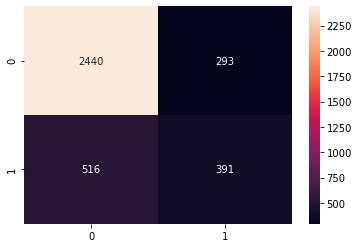

In [19]:
best_random = rf_random.best_estimator_
y_rand = best_random.predict(X_valid)

#confusion matrix
cm_rand = confusion_matrix(y_valid, y_rand)
sns.heatmap(cm_rand, annot=True, fmt="d")

In [20]:
my_class_pred_function (best_random, X_valid, y_valid, "RF Base")

,model_name,acc,auc,f1_score,recall,precision
0,RF Base,0.777747,0.788447,0.491515,0.431092,0.571637


##### 3. Grid Search

In [21]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [5],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2],
    'min_samples_split': [5],
    'n_estimators': [1200]
}
# Create a base model
rfc = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   10.6s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   10.7s finished


{'bootstrap': False,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1200}

<AxesSubplot:>

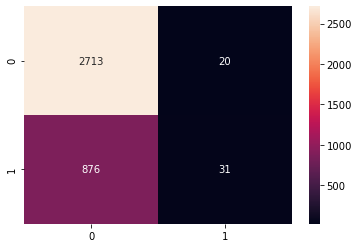

In [22]:
best_grid = grid_search.best_estimator_
y_rand = best_grid.predict(X_valid)

y_grid = grid_search.predict(X_valid)
#confusion matrix
cm_grid = confusion_matrix(y_valid, y_grid)
sns.heatmap(cm_grid, annot=True, fmt="d")

In [23]:
my_class_pred_function (best_random, X_valid, y_valid, "RF Grid")

,model_name,acc,auc,f1_score,recall,precision
0,RF Grid,0.777747,0.788447,0.491515,0.431092,0.571637


** Next Steps: **
1. As we can see clearly, the data is very imbalanced. To handle this we need to some sampling techniques, We can use SMOTE(Synthetic Minority Oversampling Technique) to make the data balanced. or any other techniques like sample weight iterations, class weight etc..
2. Tune further on Grid Serach or Random Search
3. Increase the number of iterations and add more paratmeters while training
4. Select best parameter and again retune the model further
5. Also try HyperOpt or bayesian optimisation to select the best parameter
6. Run K-Fold validation

In [24]:
## Model summary
a = my_class_pred_function (best_random, X_valid, y_valid, "RF Random")
b = my_class_pred_function (best_grid, X_valid, y_valid, "RF Grid")
c = my_class_pred_function (rf1_v1, X_valid, y_valid, "RF Base")
a.append([b,c])

,model_name,acc,auc,f1_score,recall,precision
0,RF Random,0.777747,0.788447,0.491515,0.431092,0.571637
0,RF Grid,0.753846,0.765403,0.064718,0.034179,0.607843
0,RF Base,0.771429,0.776113,0.463918,0.396913,0.558140


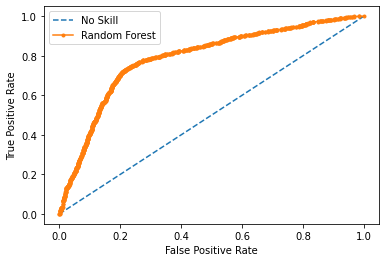

In [25]:
# plot the roc curve for the best model (RF Grid)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_valid,best_random.predict_proba(X_valid)[:,1])
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [26]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.246909, G-Mean=0.756


In [27]:
f1_score(y_valid,np.where(best_grid.predict_proba(X_valid)[:,1]>=0.246909,1,0))

0.5612682090831191

###### Predict Unseen Data using the best model

In [28]:
rf_score = best_random.predict_proba(data_unseen[my_independet_var_list])[:,1]
data_unseen['rf_score'] = rf_score

In [29]:
### Check Actual data distributions
data_unseen.target_var.value_counts()

0    717
1    241
Name: target_var, dtype: int64

In [30]:
print('DS in top 50 predictions of RF model: ',data_unseen.sort_values('rf_score',ascending=False).head(50)['target_var'].sum())
print('DS in top 100 predictions of RF model: ',data_unseen.sort_values('rf_score',ascending=False).head(100)['target_var'].sum())
print('DS in top 241 predictions of RF model: ',data_unseen.sort_values('rf_score',ascending=False).head(241)['target_var'].sum())

DS in top 50 predictions of RF model:  31
DS in top 100 predictions of RF model:  63
DS in top 241 predictions of RF model:  139


In [31]:
139/241

0.5767634854771784

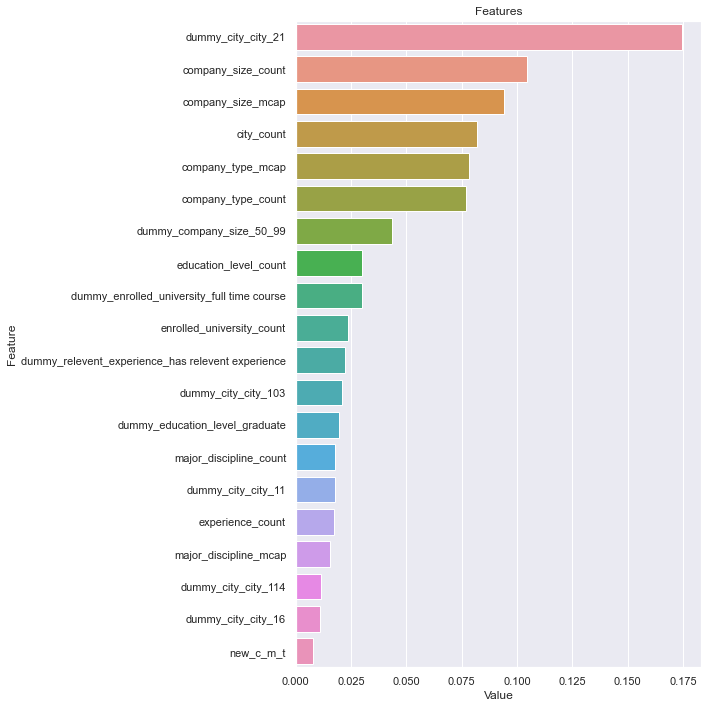

In [32]:
### Variable Importance - Top 20 Features
plot_importance(best_grid, X_train[my_independet_var_list], num=20)

### 2. XGBoost Model

In [33]:
from xgboost import XGBClassifier

##### 1. Defalut parameter XGB Model

In [34]:
### 1. Base Model
xgb_base = XGBClassifier(random_state = 0)
xgb_base.fit(X_train, y_train)

#predicting test set
xgb_base_pred = xgb_base.predict(X_valid)
accuracy_score(y_valid, xgb_base_pred)

[12:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7851648351648352

<AxesSubplot:>

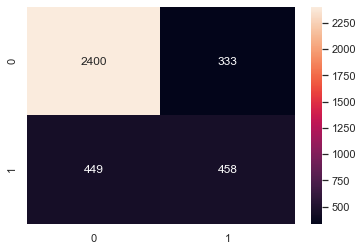

In [35]:
cm_base_xgb =  confusion_matrix(y_valid, xgb_base_pred)
sns.heatmap(cm_base_xgb, annot=True, fmt="d")

In [36]:
my_class_pred_function (xgb_base, X_valid, y_valid, "XGB Base")

,model_name,acc,auc,f1_score,recall,precision
0,XGB Base,0.785165,0.784462,0.539458,0.504961,0.579014


##### 2. Random Search parameter XGB Model

In [37]:
# Selected parameter to run the random search for XGBoost
params = {
        'min_child_weight': [1, 5],
        'learning_rate': [0.01, 1],
        'n_estimators': [100, 1000],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3, 4, 5]
        }

In [38]:
params

{'min_child_weight': [1, 5],
 'learning_rate': [0.01, 1],
 'n_estimators': [100, 1000],
 'gamma': [0.5, 1, 1.5, 2, 5],
 'subsample': [0.6, 0.8],
 'colsample_bytree': [0.6, 0.8],
 'max_depth': [3, 4, 5]}

In [39]:
xgb_clf = XGBClassifier(objective='binary:logistic',silent=True, random_state = 0)

In [40]:
xgb_random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=4, cv=3, random_state=1001 )
xgb_random_search.fit(X_train, y_train)

[12:05:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:05:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           scale_pos_weight=None, silent=True,
                                           subsample=None, tree_method=None,
                         

<AxesSubplot:>

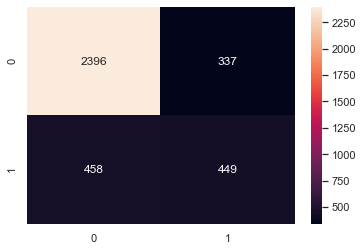

In [41]:
best_random_xgb = xgb_random_search.best_estimator_
y_rand_xgb = best_random_xgb.predict(X_valid)

#confusion matrix
cm_rand_xgb = confusion_matrix(y_valid, y_rand_xgb)
sns.heatmap(cm_rand_xgb, annot=True, fmt="d")

In [42]:
my_class_pred_function (best_random_xgb, X_valid, y_valid, "XGB Random")

,model_name,acc,auc,f1_score,recall,precision
0,XGB Random,0.781593,0.789451,0.530419,0.495039,0.571247


##### 3. Grid Search parameter XGB Model

In [44]:
# Selected parameter to run the random search for XGBoost
params = {
        'min_child_weight': [1],
        'learning_rate': [0.01],
        'n_estimators': [600],
        'gamma': [0.5],
        'subsample': [0.6],
        'colsample_bytree': [0.6],
        'max_depth': [3, 4, 5]
        }

In [45]:
xgb_grid_search = GridSearchCV(xgb_clf, param_grid=params, n_jobs=-1, cv=3)
xgb_grid_search.fit(X_train, y_train)

[12:07:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:07:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=0,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, silent=True,
                                     subsample=None, tree_me

<AxesSubplot:>

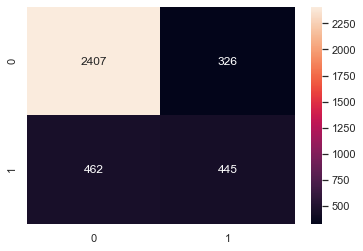

In [46]:
best_grid_xgb = xgb_grid_search.best_estimator_
y_grid_xgb = best_grid_xgb.predict(X_valid)

#confusion matrix
cm_grid_xgb = confusion_matrix(y_valid, y_grid_xgb)
sns.heatmap(cm_grid_xgb, annot=True, fmt="d")

In [47]:
my_class_pred_function (best_grid_xgb, X_valid, y_valid, "XGB Grid")

,model_name,acc,auc,f1_score,recall,precision
0,XGB Grid,0.783516,0.791559,0.530393,0.490628,0.577173


In [48]:
## Model summary
a = my_class_pred_function (best_random_xgb, X_valid, y_valid, "XGB Random")
b = my_class_pred_function (best_grid_xgb, X_valid, y_valid, "XGB Grid")
c = my_class_pred_function (xgb_base, X_valid, y_valid, "XGB Base")
a.append([b,c])

,model_name,acc,auc,f1_score,recall,precision
0,XGB Random,0.781593,0.789451,0.530419,0.495039,0.571247
0,XGB Grid,0.783516,0.791559,0.530393,0.490628,0.577173
0,XGB Base,0.785165,0.784462,0.539458,0.504961,0.579014


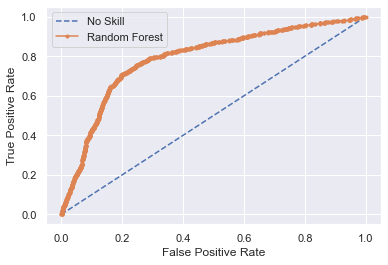

In [49]:
# plot the roc curve for the best model (RF Grid)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_valid,best_random_xgb.predict_proba(X_valid)[:,1])
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [50]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.201174, G-Mean=0.754


In [51]:
f1_score(y_valid,np.where(best_random_xgb.predict_proba(X_valid)[:,1]>=0.201174,1,0))

0.6033568904593639

###### Predict Unseen Data using the best model

In [52]:
xgb_score = best_random_xgb.predict_proba(data_unseen[my_independet_var_list])[:,1]
data_unseen['xgb_score'] = xgb_score

In [53]:
print('DS in top 50 predictions of XGB model: ',data_unseen.sort_values('xgb_score',ascending=False).head(50)['target_var'].sum())
print('DS in top 100 predictions of XGB model: ',data_unseen.sort_values('xgb_score',ascending=False).head(100)['target_var'].sum())
print('DS in top 241 predictions of XGB model: ',data_unseen.sort_values('xgb_score',ascending=False).head(241)['target_var'].sum())

DS in top 50 predictions of XGB model:  38
DS in top 100 predictions of XGB model:  65
DS in top 241 predictions of XGB model:  143


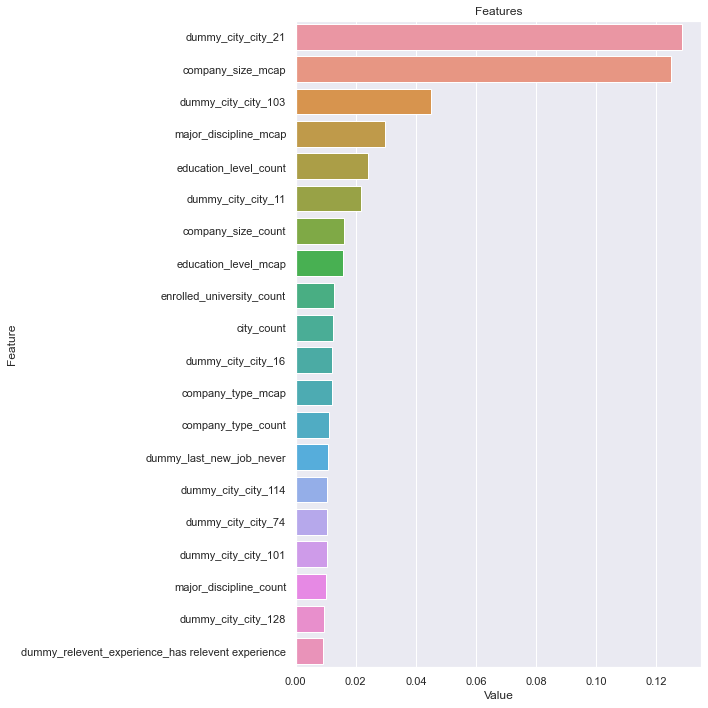

In [54]:
### Variable Importance - Top 20 Features
plot_importance(best_random_xgb, X_train[my_independet_var_list], num=20)

### Fianl Score 

In [55]:
my_pred = data_unseen[['enrollee_id', 'rf_score','xgb_score','target_var']].copy()
my_pred.head(10)

,enrollee_id,rf_score,xgb_score,target_var
0,4167,0.117285,0.087252,0
1,6491,0.240631,0.292684,0
2,13238,0.620202,0.531937,0
3,29975,0.472066,0.425892,0
4,20970,0.309065,0.336104,0
5,25413,0.105243,0.142280,0
6,7364,0.089313,0.112019,0
7,5220,0.390640,0.418200,0
8,11338,0.067694,0.089792,0
9,15637,0.122874,0.079710,0


In [56]:
my_pred['ensemble_prob'] = my_pred[['rf_score','xgb_score']].mean(axis=1)
my_pred.head(4)

,enrollee_id,rf_score,xgb_score,target_var,ensemble_prob
0,4167,0.117285,0.087252,0,0.102269
1,6491,0.240631,0.292684,0,0.266657
2,13238,0.620202,0.531937,0,0.576069
3,29975,0.472066,0.425892,0,0.448979


In [57]:
print('DS in top 50 predictions of ensemble model: ',my_pred.sort_values('ensemble_prob',ascending=False).head(50)['target_var'].sum())
print('DS in top 100 predictions of ensemble model: ',my_pred.sort_values('ensemble_prob',ascending=False).head(100)['target_var'].sum())
print('DS in top 241 predictions of ensemble model: ',my_pred.sort_values('ensemble_prob',ascending=False).head(241)['target_var'].sum())

DS in top 50 predictions of ensemble model:  34
DS in top 100 predictions of ensemble model:  64
DS in top 241 predictions of ensemble model:  139
